# Warum ist die Banane krumm?

In [26]:
import sys, os
import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2
import palettable
from astropy.cosmology import Planck15

sys.path.append('../')
import paper_settings
from simulation.units import *
from simulation.profiles import MassProfileNFW, MassProfileSIE
from simulation.population_sim import SubhaloPopulation


## Grid

In [27]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

## Load likelihood contours for comparison

In [59]:
filename = "alices_full"
setting = "full"
llr = np.mean(np.load("../data/results/llr_{}_grid.npy".format(filename)), axis=-1)
llr = -2. * llr
llr -= np.min(llr)

In [60]:
n_for_lines = [100, 20, 5, 1]
thresholds = [1. / n * chi2.isf(0.05, df=2) for n in n_for_lines]
contour_ls = ["-", "--", "-.", ":"]
clabels = ["100", "20", "5", "1"]

## Calculate quantities

In [28]:
def M_200_sigma_v(sigma_v, scatter=False):
    """
    Relate central velocity dispersion to halo virial mass
    From https://arxiv.org/pdf/1804.04492.pdf
    """
    a = 0.09
    b = 3.48
    if scatter:
        sigma_log10_M_200 = 0.13  # Lognormal scatter
        log10_M_200 = np.random.normal(a + b * np.log10(sigma_v / (100 * Kmps)), sigma_log10_M_200)
    else:
        log10_M_200 = a + b * np.log10(sigma_v / (100 * Kmps))
    return (10 ** log10_M_200) * 1e12 * M_s

In [57]:
def calculate_summaries(f_sub, beta, n=1000):
    if np.abs((beta + 2.)) < 1.e-3:
        beta = -2.001
    
    mhosts, total_msubs, avg_msubs, nsubs = [], [], [], []
    
    for i in range(n):
        m_min_calib=1e6 * M_s
        m_max_sub_div_M_hst_calib=0.01
        m_200_min_sub=1e7 * M_s
        m_200_max_sub_div_M_hst=0.01
        roi_size=2.
        M_200_sigma_v_scatter = True
        
        z_l = 2.0
        while z_l > 1.0:
            z_l = 10 ** np.random.normal(-0.25, 0.25)
        sigma_v = np.random.normal(225, 50)
        
        theta_s_e = 0.2
        z_s = 1.5
        mag_s = 23.0
        
        D_l = Planck15.angular_diameter_distance(z=z_l).value * Mpc
        D_s = Planck15.angular_diameter_distance(z=z_s).value * Mpc
        D_ls = Planck15.angular_diameter_distance_z1z2(z1=z_l, z2=z_s).value * Mpc
        
        M_200_hst = M_200_sigma_v(sigma_v * Kmps, scatter=M_200_sigma_v_scatter)
        c_200_hst = MassProfileNFW.c_200_SCP(M_200_hst)
        r_s_hst, rho_s_hst = MassProfileNFW.get_r_s_rho_s_NFW(M_200_hst, c_200_hst)
        theta_E = MassProfileSIE.theta_E(sigma_v * Kmps, D_ls, D_s)
        
        f_sub_realiz = 2.0
        while f_sub_realiz > 1.0:
            ps = SubhaloPopulation(
                f_sub=f_sub,
                beta=beta,
                M_hst=M_200_hst,
                c_hst=c_200_hst,
                m_min=m_200_min_sub,
                m_max=m_200_max_sub_div_M_hst * M_200_hst,
                m_min_calib=m_min_calib,
                m_max_calib=m_max_sub_div_M_hst_calib * M_200_hst,
                theta_s=r_s_hst / D_l,
                theta_roi=roi_size * theta_E,
                theta_E=theta_E,
                params_eval=[],
                calculate_joint_score=False,
            )
            f_sub_realiz = ps.f_sub_realiz
            
        mhosts.append(ps.M_hst_roi/M_s)
        total_msubs.append(np.sum(ps.m_sample/M_s))
        avg_msubs.append(np.nanmean(ps.m_sample/M_s))
        nsubs.append(ps.n_sub_roi)
    
    mean_total_msub = np.nanmean(total_msubs)
    mean_fsub = np.nanmean(np.asarray(total_msubs) / np.asarray(mhosts))
    mean_msub = np.nanmean(avg_msubs)
    mean_nsub = np.nanmean(nsubs)
    
    return mean_total_msub, mean_fsub, mean_msub, mean_nsub

## Run

In [58]:
mean_total_msubs, mean_fsubs, mean_msubs, mean_nsubs = [], [], [], []

for i, theta in enumerate(theta_grid):
    print(i, theta)
    mean_total_msub, mean_fsub, mean_msub, mean_nsub = calculate_summaries(theta[0], theta[1])
    mean_total_msubs.append(mean_total_msub)
    mean_fsubs.append(mean_fsub)
    mean_msubs.append(mean_msub)
    mean_nsubs.append(mean_nsub)

0 [ 1.0e-03 -2.5e+00]


/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


1 [ 0.00929167 -2.5       ]
2 [ 0.01758333 -2.5       ]
3 [ 0.025875 -2.5     ]
4 [ 0.03416667 -2.5       ]
5 [ 0.04245833 -2.5       ]
6 [ 0.05075 -2.5    ]
7 [ 0.05904167 -2.5       ]
8 [ 0.06733333 -2.5       ]
9 [ 0.075625 -2.5     ]
10 [ 0.08391667 -2.5       ]
11 [ 0.09220833 -2.5       ]
12 [ 0.1005 -2.5   ]
13 [ 0.10879167 -2.5       ]
14 [ 0.11708333 -2.5       ]
15 [ 0.125375 -2.5     ]
16 [ 0.13366667 -2.5       ]
17 [ 0.14195833 -2.5       ]
18 [ 0.15025 -2.5    ]
19 [ 0.15854167 -2.5       ]
20 [ 0.16683333 -2.5       ]
21 [ 0.175125 -2.5     ]
22 [ 0.18341667 -2.5       ]
23 [ 0.19170833 -2.5       ]
24 [ 0.2 -2.5]
25 [ 1.00000000e-03 -2.45833333e+00]
26 [ 0.00929167 -2.45833333]
27 [ 0.01758333 -2.45833333]
28 [ 0.025875   -2.45833333]
29 [ 0.03416667 -2.45833333]
30 [ 0.04245833 -2.45833333]
31 [ 0.05075    -2.45833333]
32 [ 0.05904167 -2.45833333]
33 [ 0.06733333 -2.45833333]
34 [ 0.075625   -2.45833333]
35 [ 0.08391667 -2.45833333]
36 [ 0.09220833 -2.45833333]
37 [ 0.

/Users/johannbrehmer/anaconda3/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


216 [ 0.13366667 -2.16666667]
217 [ 0.14195833 -2.16666667]
218 [ 0.15025    -2.16666667]
219 [ 0.15854167 -2.16666667]
220 [ 0.16683333 -2.16666667]
221 [ 0.175125   -2.16666667]
222 [ 0.18341667 -2.16666667]
223 [ 0.19170833 -2.16666667]
224 [ 0.2        -2.16666667]
225 [ 1.000e-03 -2.125e+00]
226 [ 0.00929167 -2.125     ]
227 [ 0.01758333 -2.125     ]
228 [ 0.025875 -2.125   ]
229 [ 0.03416667 -2.125     ]
230 [ 0.04245833 -2.125     ]
231 [ 0.05075 -2.125  ]
232 [ 0.05904167 -2.125     ]
233 [ 0.06733333 -2.125     ]
234 [ 0.075625 -2.125   ]
235 [ 0.08391667 -2.125     ]
236 [ 0.09220833 -2.125     ]
237 [ 0.1005 -2.125 ]
238 [ 0.10879167 -2.125     ]
239 [ 0.11708333 -2.125     ]
240 [ 0.125375 -2.125   ]
241 [ 0.13366667 -2.125     ]
242 [ 0.14195833 -2.125     ]
243 [ 0.15025 -2.125  ]
244 [ 0.15854167 -2.125     ]
245 [ 0.16683333 -2.125     ]
246 [ 0.175125 -2.125   ]
247 [ 0.18341667 -2.125     ]
248 [ 0.19170833 -2.125     ]
249 [ 0.2   -2.125]
250 [ 1.00000000e-03 -2.0833

495 [ 0.16683333 -1.70833333]
496 [ 0.175125   -1.70833333]
497 [ 0.18341667 -1.70833333]
498 [ 0.19170833 -1.70833333]
499 [ 0.2        -1.70833333]
500 [ 1.00000000e-03 -1.66666667e+00]
501 [ 0.00929167 -1.66666667]
502 [ 0.01758333 -1.66666667]
503 [ 0.025875   -1.66666667]
504 [ 0.03416667 -1.66666667]
505 [ 0.04245833 -1.66666667]
506 [ 0.05075    -1.66666667]
507 [ 0.05904167 -1.66666667]
508 [ 0.06733333 -1.66666667]
509 [ 0.075625   -1.66666667]
510 [ 0.08391667 -1.66666667]
511 [ 0.09220833 -1.66666667]
512 [ 0.1005     -1.66666667]
513 [ 0.10879167 -1.66666667]
514 [ 0.11708333 -1.66666667]
515 [ 0.125375   -1.66666667]
516 [ 0.13366667 -1.66666667]
517 [ 0.14195833 -1.66666667]
518 [ 0.15025    -1.66666667]
519 [ 0.15854167 -1.66666667]
520 [ 0.16683333 -1.66666667]
521 [ 0.175125   -1.66666667]
522 [ 0.18341667 -1.66666667]
523 [ 0.19170833 -1.66666667]
524 [ 0.2        -1.66666667]
525 [ 1.000e-03 -1.625e+00]
526 [ 0.00929167 -1.625     ]
527 [ 0.01758333 -1.625     ]
528 

## Plot

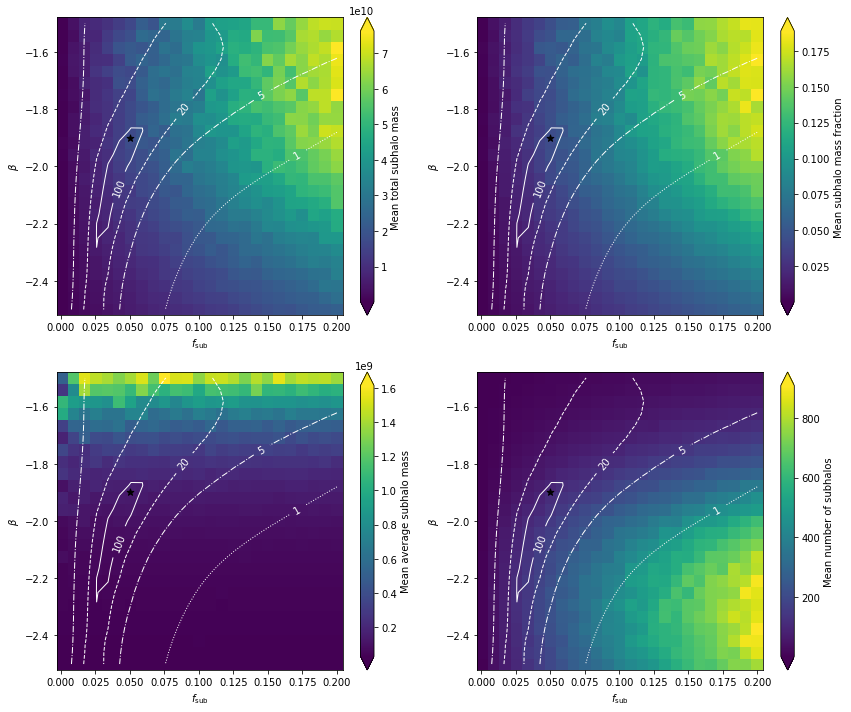

In [62]:
fig = plt.figure(figsize=(12,10))

for i, (data, label) in enumerate(zip(
    [mean_total_msubs, mean_fsubs, mean_msubs, mean_nsubs],
    ["Mean total subhalo mass", "Mean subhalo mass fraction", "Mean average subhalo mass", "Mean number of subhalos"]
)):
    ax = plt.subplot(2,2,i+1)
    data = np.asarray(data).reshape(25,25)
    
    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        data,
        #norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
        cmap="viridis"
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(0.05, -1.9, s=50., color='black', marker='*')
    cs = ax.contour(
        0.5 * (alpha_edges[1:] + alpha_edges[:-1]),
        0.5 * (beta_edges[1:] + beta_edges[:-1]),
        llr.reshape((resolution, resolution)),
        thresholds,
        colors="white",
        linewidths=1.,
        linestyles=contour_ls,
    )
    
    plt.clabel(cs, fmt={thresholds[i] : clabels[i] for i in range(len(thresholds))},
          manual=[(0.04,-2.07), (0.09,-1.8), (0.14,-1.7), (0.17,-1.95)])
    plt.xlabel(r'$f_{\mathrm{sub}}$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(label)
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])  
    
plt.tight_layout()
plt.savefig("../figures/other/understand_the_banana.pdf")
